In [1]:
import tensorflow as tf
from tensorflow.python.ops.rnn import _transpose_batch_time

from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy, time, glob, os, sys
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"

# customized ftns 
from helpers import *
from utilities import LoadData, PlotGame, make_video
from model import rnn_horizon
# ---------------------------------------------------------
%matplotlib inline
%load_ext autoreload
%autoreload 2

# ---------------------------------------------------------
# directories
main_dir = '../'
game_dir = main_dir+'data/'
Data = LoadData(main_dir, game_dir)

/home/sam/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/sam/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Load raw data

In [2]:
# %%time
game_id = '0021500463'
game_data = Data.load_game(game_id)
events_df = pd.DataFrame(game_data['events'])
print('raw events shape:', events_df.shape)
events_df.head(3)

raw events shape: (231, 8)


,end_time_left,home,moments,orig_events,playbyplay,quarter,start_time_left,visitor
0,702.31,"{'abbreviation': 'CHI', 'players': [{'playerid...","[[1, 1451351428029, 708.28, 12.78, None, [[-1,...",[0],GAME_ID EVENTNUM EVENTMSGTYPE EVENTMS...,1,708.28,"{'abbreviation': 'TOR', 'players': [{'playerid..."
1,686.28,"{'abbreviation': 'CHI', 'players': [{'playerid...","[[1, 1451351428029, 708.28, 12.78, None, [[-1,...",[1],GAME_ID EVENTNUM EVENTMSGTYPE EVENTMS...,1,708.28,"{'abbreviation': 'TOR', 'players': [{'playerid..."
2,668.42,"{'abbreviation': 'CHI', 'players': [{'playerid...","[[1, 1451351444029, 692.25, 12.21, None, [[-1,...","[2, 3]",GAME_ID EVENTNUM EVENTMSGTYPE EVENTMS...,1,692.25,"{'abbreviation': 'TOR', 'players': [{'playerid..."


#### Get some suplementary data

In [3]:
# play id to play roles/positions
id_role = id_position(events_df)
check_game_roles_duplicates(id_role)

# we will use this fixed order as the role order
roles = ['F', 'G', 'C-F', 'G-F', 'F-G', 'C', 'F-C']
role_order = {'F': 0, 'G':4, 'C-F':1, 'G-F':3, 'F-G':3, 'C':2, 'F-C':1}

# its possible that F has similar role as G-f or F-G, we create empty slots to ensure meta order
# ddentify defending and offending runs (this is included in process_moments)
court_index = Data.load_csv('./meta_data/court_index.csv')
court_index = dict(zip(court_index.game_id, court_index.court_position))

# home and visitor ids
homeid = events_df.loc[0].home['teamid']
awayid = events_df.loc[0].visitor['teamid']

#### Pre-process

In [4]:
# filter out actions except 1: Make, 2: Miss, 4: Rebound, 6:Personal Foul, 7:Violation
use_event = [1, 2, 4, 6, 7]
discard_event = [3, 5, 8, 9, 10, 12, 13, 18]
events = filter_event_type(events_df, discard_event)
print('After filtering events has shape:', events.shape)
# break up sequences at 24secs shot clock point (or irregular case, e.g. out of bound maybe),
# and obtain the game data
single_game = get_game_data(events, id_role, role_order, court_index, game_id, 
                            event_threshold=10, subsample_factor=2)
print('Final number of events:', len(single_game))

After filtering events has shape: (134, 8)
subsample enabled with subsample factor 2
Final number of events: 165


In [5]:
single_game[0].shape

(19, 67)

#### Show the plot, for the sake of comparison with processed moment later on

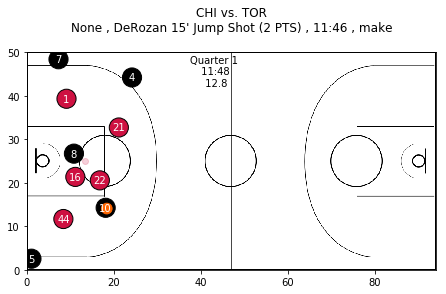

In [6]:
Plot = PlotGame(game_id, main_dir, game_dir)
# for i in range(plotn): 
Plot.load_moment2img(game_data, event_number=0, moment_number=0, return_img=True)

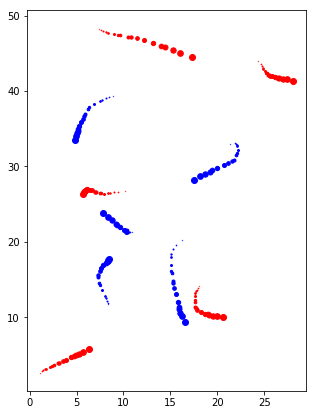

In [7]:
# cerate a simple plot shows the trajectory
g = single_game[0]
plt.figure(figsize=(5,7))
extreme = 3 
# create color scheme
c = ['b']*30 + ['r']*30
for i in range(0, extreme*10*2, 2): # extreme=3, palyers=10, x,y=2
    x_i, y_i = g[:, i], g[:, i+1]
    if sum(x_i) !=0 and sum(y_i) != 0:
        for k in range(0, len(x_i)):
            plt.plot(x_i[k], y_i[k], linestyle="None", marker="o", markersize=k/3, color=c[i])

#### Create label, train and test set

In [8]:
# lets first predict role F (ignored the extreme)
game_target = [np.roll(i[:, :2], -1, axis=0)[:-1, :] for i in single_game] # drop the last row as the rolled-back is not real
game_data = [i[:-1, :] for i in single_game] # also need to drop the last element as it does not have next timestep
# create train and test set
p = 0.8 # train percentage
divider = int(len(single_game)*p)
train_game, test_game = game_data[:divider], game_data[divider:]
train_target, test_target = game_target[:divider], game_target[divider:]

In [9]:
game_data[0].shape

(18, 67)

In [10]:
game_target[0].shape

(18, 2)

In [11]:
game_data[1].shape

(18, 67)

In [12]:
game_data[2].shape

(75, 67)

#### Build graph and starts training

In [14]:
tf.reset_default_graph()
# use training start time as the unique naming
train_time = datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
logs_path = './train_logs/'

# hyper-parameters
# num_layers = 2
state_size = 128
batch_size = 64
dimx = 67
dimy = 2
learning_rate = 0.001

# lstm cells
# lstm1 = tf.contrib.rnn.BasicLSTMCell(state_size, forget_bias=1.)
# lstm1 = tf.nn.rnn_cell.DropoutWrapper(lstm1, output_keep_prob=0.8)

# lstm2 = tf.contrib.rnn.BasicLSTMCell(state_size, forget_bias=1.)
# lstm2 = tf.nn.rnn_cell.DropoutWrapper(lstm2, output_keep_prob=0.8)

# lstm_cell = tf.contrib.rnn.MultiRNNCell([lstm1, lstm2])

# a single lstm layer
lstm_cell = tf.contrib.rnn.BasicLSTMCell(state_size, forget_bias=1.)
lstm_cell = tf.nn.rnn_cell.DropoutWrapper(lstm_cell, output_keep_prob=0.7)

# initial state
initial_state = lstm_cell.zero_state(batch_size, dtype=tf.float32)

# input placeholders
h = tf.placeholder(tf.int32)
X = tf.placeholder(tf.float32, [batch_size, None, dimx], name = 'train_input')
Y = tf.placeholder(tf.float32, [batch_size, None, dimy], name = 'train_label')
# rnn structure
output, last_states = rnn_horizon(cell=lstm_cell, 
                                  initial_state=initial_state, 
                                  input_=X,
                                  batch_size=batch_size,
                                  seq_lengths=h,
                                  output_dim=dimy)
# output as the prediction
print('output shape, last_states', output.shape, last_states)
pred = output
print('label shape:{0:} | output prediction shape: {1:}'.format(Y.shape, pred.shape))

# tensorboard's graph visualization more convenient
with tf.name_scope('MSEloss'):
    # loss (also add regularization on params)
    tv = tf.trainable_variables()
    # l2 weight loss
#     regularization_cost = tf.reduce_sum([tf.nn.l2_loss(v) for v in tv])
    # l1 loss
#     l1_regularizer = tf.contrib.layers.l1_regularizer(scale=0.005, scope=None)
#     regularization_cost = tf.contrib.layers.apply_regularization(l1_regularizer, tv)

#     loss = tf.losses.mean_squared_error(Y, pred) + regularization_cost
    # no weight loss
    loss = tf.losses.mean_squared_error(Y, pred)
with tf.name_scope('Adam'):
    # optimzier
    opt = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
# initialize variables
init = tf.global_variables_initializer()
# create a summary to monitor cost tensor
train_summary = tf.summary.scalar("TrainMSEloss", loss)
valid_summary = tf.summary.scalar("ValidMSEloss", loss)
# # Merge all summaries into a single op
# merged_summary_op = tf.summary.merge_all()


# session
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# initializing the variables
sess.run(init)
# op to write logs to Tensorboard
train_writer = tf.summary.FileWriter(logs_path+'/train'+train_time, graph=tf.get_default_graph())
valid_writer = tf.summary.FileWriter(logs_path+'/valid'+train_time, graph=tf.get_default_graph())

# ===============================================================================================

# start training
printn = int(1e2)    # how many epochs we print
# horizon = [2, 4, 8, 12, 16, 20, 25]
horizon = range(1, 5)
n_epochs = [500, 500, 1000, 1000]
t_int = time.time()
train_step = 0
valid_step = 0
for k in range(len(horizon)):
    # look-ahead horizon
    seq_len = horizon[k]
    print('Horizon {0:} {1:}'.format(seq_len, '='*10))

    # train x
    train_x = copy.deepcopy([get_sequences(i, seq_len, dimx) for i in train_game])
    train_x = copy.deepcopy(np.concatenate(train_x, axis=0))
    print('train_x.shape:', train_x.shape)
    # train y
    train_y = copy.deepcopy([get_sequences(i, seq_len, dimy) for i in train_target])
    train_y = copy.deepcopy(np.concatenate(train_y, axis=0))
    print('train_y.shape:', train_y.shape)
    
    # valid x
    val_x = copy.deepcopy([get_sequences(i, seq_len, dimx) for i in test_game])
    val_x = copy.deepcopy(np.concatenate(val_x, axis=0))
    print('valid_x.shape:', val_x.shape)
    # valid y
    val_y = copy.deepcopy([get_sequences(i, seq_len, dimy) for i in test_target])
    val_y = copy.deepcopy(np.concatenate(val_y, axis=0))
    print('valid_y.shape:', val_y.shape)
    
    for epoch in range(n_epochs[k]):
        epoch_loss =0.
        # number of train batches
        n_train_batch = train_x.shape[0]//batch_size
        t1 = time.time()
        for batch in iterate_minibatches(train_x, train_y, batch_size, shuffle=False):
            train_xi, train_yi = batch
            p, l, _, train_sum = sess.run([output, loss, opt, train_summary], 
                                        feed_dict={X: train_xi, Y: train_yi, h:seq_len})
            train_writer.add_summary(train_sum, train_step)
            epoch_loss += l/n_train_batch
            train_step += 1
        # print out info
        if epoch%printn ==0:
            # number of validation batches
            n_val_batch = val_x.shape[0]//batch_size
            t2 = time.time()
            valid_loss = 0
            for batch in iterate_minibatches(val_x, val_y, batch_size, shuffle=False):
                val_xi, val_yi = batch
                val_l, valid_sum = sess.run([loss, train_summary], 
                                            feed_dict={X: val_xi, Y: val_yi, h:seq_len})
                valid_writer.add_summary(valid_sum, valid_step)
                valid_loss += val_l/n_val_batch
                valid_step += printn
            print('Epoch {0:<4d} | loss: {1:<8.2f} | time took: {2:<.2f}s '
                  '| validation loss: {3:<8.2f}'.format(epoch, epoch_loss, (t2-t1), valid_loss))
                

t_end = time.time()
print('Total time took: {0:<.2f}hrs'.format((time.time()-t_int)/60/60))
# sess.close()
# # save model
# #Create a saver object which will save all the variables
# saver = tf.train.Saver()
# #save the graph
# saver.save(sess, save_path='./models/test_model')

output shape, last_states (64, ?, 2) LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_4:0' shape=(64, 128) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_5:0' shape=(64, 128) dtype=float32>)
label shape:(64, ?, 2) | output prediction shape: (64, ?, 2)
Horizon 1 ==========
train_x.shape: (8270, 1, 67)
train_y.shape: (8270, 1, 2)
valid_x.shape: (2167, 1, 67)
valid_y.shape: (2167, 1, 2)
Epoch 0    | loss: 207.79   | time took: 0.33s | validation loss: 97.34   
Epoch 100  | loss: 5.04     | time took: 0.21s | validation loss: 16.83   
Epoch 200  | loss: 4.22     | time took: 0.22s | validation loss: 13.16   
Epoch 300  | loss: 3.55     | time took: 0.18s | validation loss: 14.18   
Epoch 400  | loss: 3.24     | time took: 0.19s | validation loss: 12.89   
Horizon 2 ==========
train_x.shape: (4106, 2, 67)
train_y.shape: (4106, 2, 2)
valid_x.shape: (1075, 2, 67)
valid_y.shape: (1075, 2, 2)
Epoch 0    | loss: 3.84     | time took: 0.13s | validation loss: 23.53   
Epoch 100  | loss: 2.72     | time 

### Check model on train set

check_id: 89


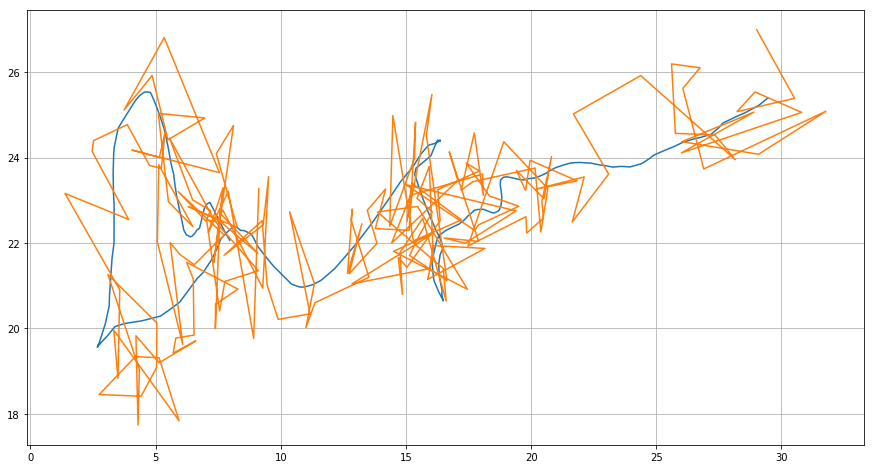

In [15]:
check_seq_len = 3

# use while loop to make sure the 
present = 0
while present == 0:
    check_ind = np.random.randint(0, len(train_game)-1)
    input_x = copy.deepcopy(get_sequences(train_game[check_ind], check_seq_len, dimx))
    output_y = copy.deepcopy(get_sequences(train_target[check_ind], check_seq_len, dimy))
    if input_x.shape[0] >= batch_size:
        print('check_id:', check_ind)
        present += 1

pred = []
y_train = []
order_x = []
for batch in iterate_minibatches(input_x, output_y, batch_size, shuffle=False):
    input_xi, output_yi = batch
    p = sess.run([output], feed_dict={X: input_xi, h:check_seq_len})#, Y: train_yi, h:2})
    pred.append(p)
    order_x.append(input_xi)
    y_train.append(output_yi)
pred_train = np.array(pred).reshape(-1,2)
y_train = np.array(y_train).reshape(-1,2)
plt.figure(figsize=(15,8))
plt.plot(y_train[:,0], y_train[:,1], pred_train[:, 0], pred_train[:, 1])
plt.grid(True)

#### Check model on test set

check_id: 27
(74, 2, 67) (74, 2, 2)


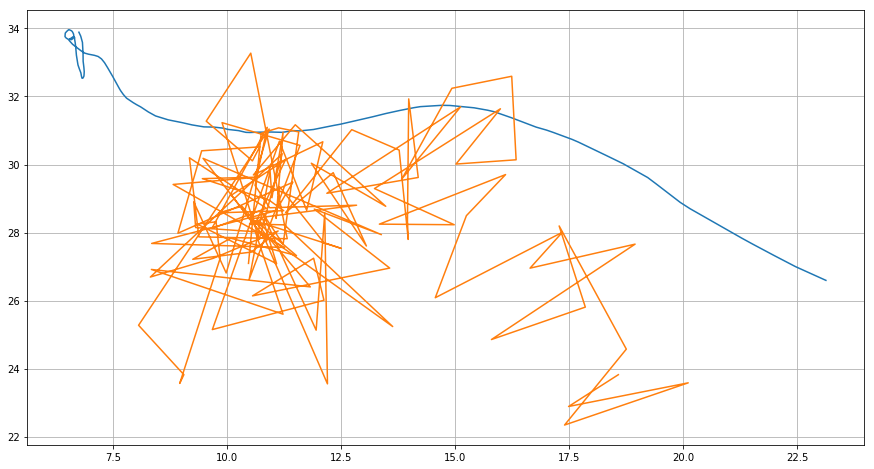

In [16]:
check_seq_len = 2

# use while loop to make sure the 
present = 0
while present == 0:
    check_ind = np.random.randint(0, len(test_game)-1)
    # check_ind = 0
#     print('check_id:', check_ind)
    input_x = copy.deepcopy(get_sequences(test_game[check_ind], check_seq_len, dimx))
#     print('input x shape >>>', input_x.shape)
    output_y = copy.deepcopy(get_sequences(test_target[check_ind], check_seq_len, dimy))
    if input_x.shape[0] >= batch_size:
        print('check_id:', check_ind)
        present += 1

pred = []
y_train = []
order_x = []
print(input_x.shape, output_y.shape)
for batch in iterate_minibatches(input_x, output_y, batch_size, shuffle=False):
    input_xi, output_yi = batch
    p = sess.run([output], feed_dict={X: input_xi, h:check_seq_len})#, Y: train_yi, h:2})
    pred.append(p)
    order_x.append(input_xi)
    y_train.append(output_yi)
pred_train = np.array(pred).reshape(-1,2)
y_train = np.array(y_train).reshape(-1,2)
plt.figure(figsize=(15,8))
plt.plot(y_train[:,0], y_train[:,1], pred_train[:, 0], pred_train[:, 1])
plt.grid(True)

#### Create video based off predictions

In [ ]:
# events.head()
# replace the true position with the predicted
events_pred = events.head(1).copy()
def replace_pos(x):
    for i in range(len(pred_train)):
#         print(x[i][5])
#         print(x[i][5][2][2:4], pred_train[i])
        x[i][5][2][2:4]=pred_train[i] 
events_pred = events_pred.moments.apply(lambda x: replace_pos(x))

In [ ]:
# save all moments for a specific events
Plot = PlotGame(game_id, main_dir, game_dir)
moments = range(len(pred_train))
event_number = 0
for i in moments:
    print(i, end='\r')
    Plot.load_pred_moment2img(game_data, event_number, i)
# PlotGame.load_pred_moment2img()

In [ ]:
#  so by comparing the position we know we are modelling the third position ind = 2
# order_x

In [ ]:
# prepare to save videos
event_dir = game_dir + 'game' + str(game_id) + '/' + 'predevent' + str(event_number) + '/'
video_name = event_dir + str(event_number) + '.mp4'
print(video_name)
images = glob.glob(event_dir + "*.png")
images = sorted(images, key=lambda x: int(x.split('.')[2].split('/')[-1][4:]))
# print(images)
# save to video
make_video(images, video_name, 15)

In [ ]:
pred_train.shape

In [ ]:
# len(events_pred.moments)

### To do:

    - 1) Regularize the lstm
    - 2) Figure out why there are blanks in the testing
    - 3) may consider to collect those left out from the process of creating batches
    - 4) related to 3), seq_len = 3 may create null batches 

    - Split data to defending and offending, as the model for e.g. forward role in deffending and offending should be pretty different. Remove particular events, like free-throw etc.
    
    - We can use the shot clock as an indicator of when the offending and defending switches.
    
    - The cameras oprate at 25 frames per second, so in order to learn realistic motions, either we sample the 25 frames, or extend the horizon to 50 for example or even longer(this might be too computationally heavy and model would probably drift a lot).
    
    - At the moment if we don't have defending or offending sepearted, at least we need to break down the sequences from the 24 secs shot clock, since it usually stands for a change in game state. (note: shot clock sometimes is None)
    
    - Add tensorboard visualization. Add validation performance (maybe, it would take longer). 
      tensorboard --logdir=./train_logs
      
    - Start thinking about 1) joint training 2) Hidden structure 3) Smooth learning
    - from each sample to next sample theres not much change, subsample them 

### Questions

    * After a team scored and they go back to get ready for defense, is the going back trajectory pretty much random?
    * Do player swap roles during the play? e.g. a forward swapped to a guard, is the forward roles a lot different from gaurds these day? (i.e. can you differentaite a player plaing forward from guard from the game) If yes, then the hidden structure learning/sequencing is necessary. 